In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sma
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df=pd.read_csv('exchange_rate.csv')

In [3]:
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [4]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [7]:
df['date']=pd.to_datetime(df['date'],format='%d-%m-%Y %H:%M')

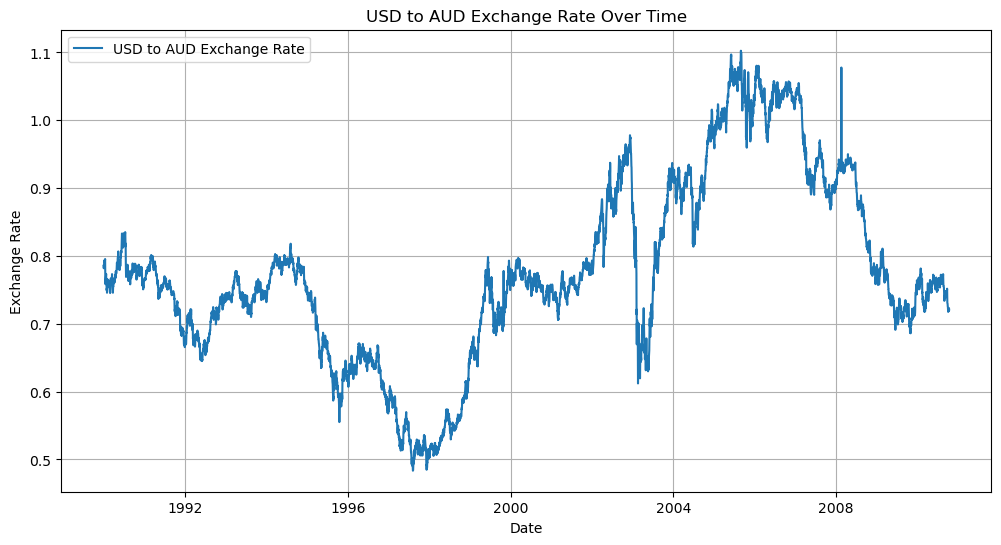

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['date'],df['Ex_rate'],label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [9]:
missing_values=df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 date       0
Ex_rate    0
dtype: int64


In [10]:
df['Ex_rate_diff']=df['Ex_rate'].diff().dropna()

### Model Building - ARIMA

#### Parameter Selection for ARIMA

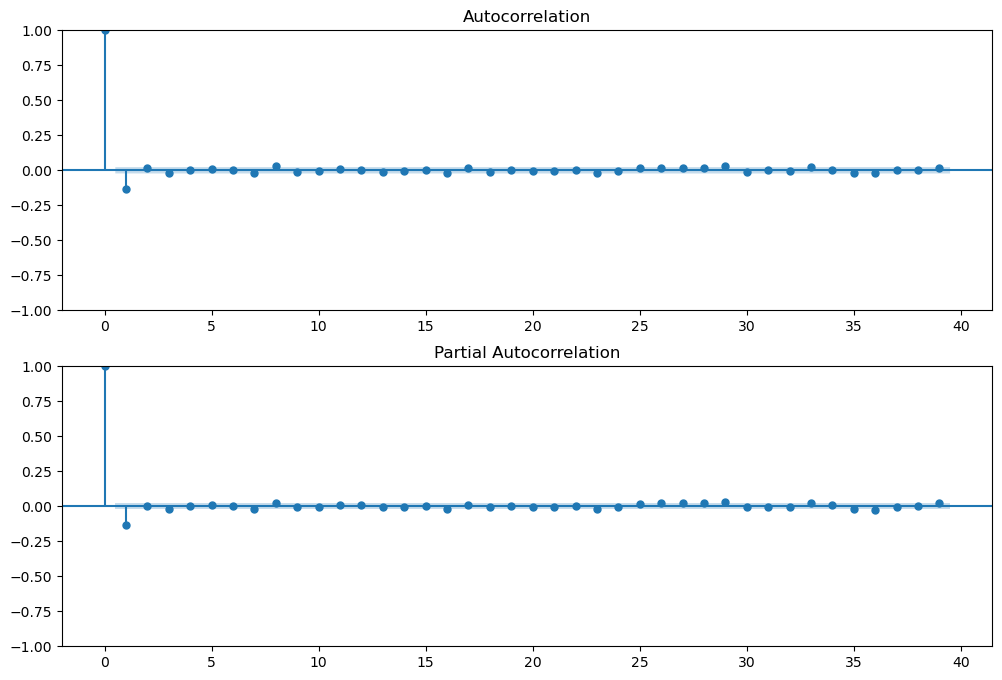

In [11]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
plot_acf(df['Ex_rate_diff'].dropna(),ax=ax[0])
plot_pacf(df['Ex_rate_diff'].dropna(),ax=ax[1])
plt.show()

#### Model Fitting

In [12]:
model=ARIMA(df['Ex_rate'],order=(1,1,1))

In [13]:
model_fit=model.fit()

#### Diagnostics

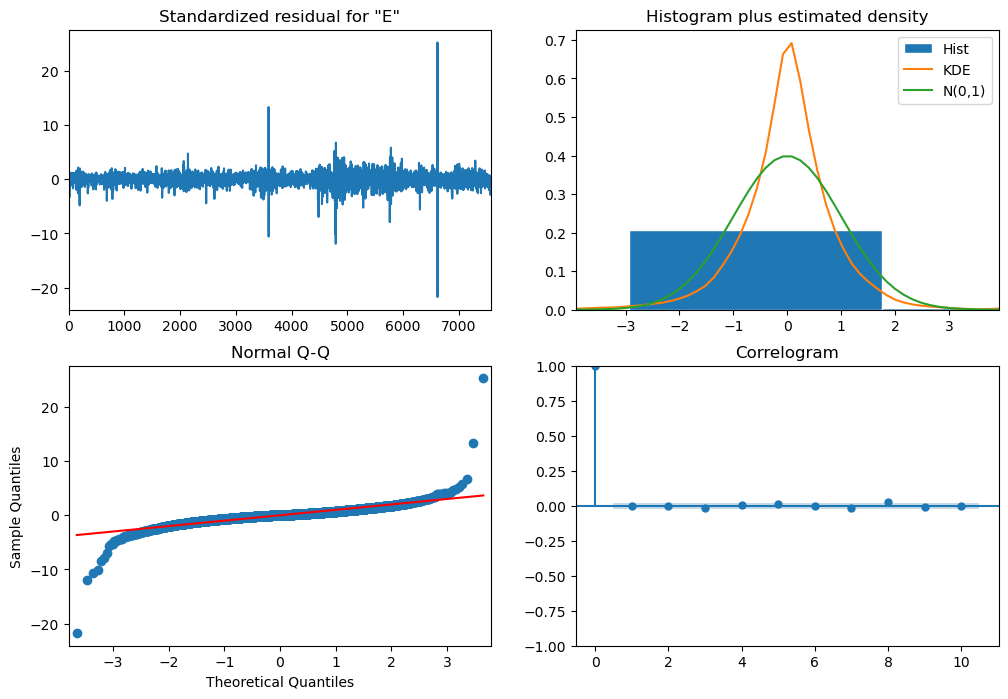

In [14]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

#### Forecasting

In [15]:
forecast_arima=model_fit.get_forecast(steps=1518)

In [16]:
forecast_index=pd.date_range(start=df['date'].iloc[-1],periods=1518,freq='D')

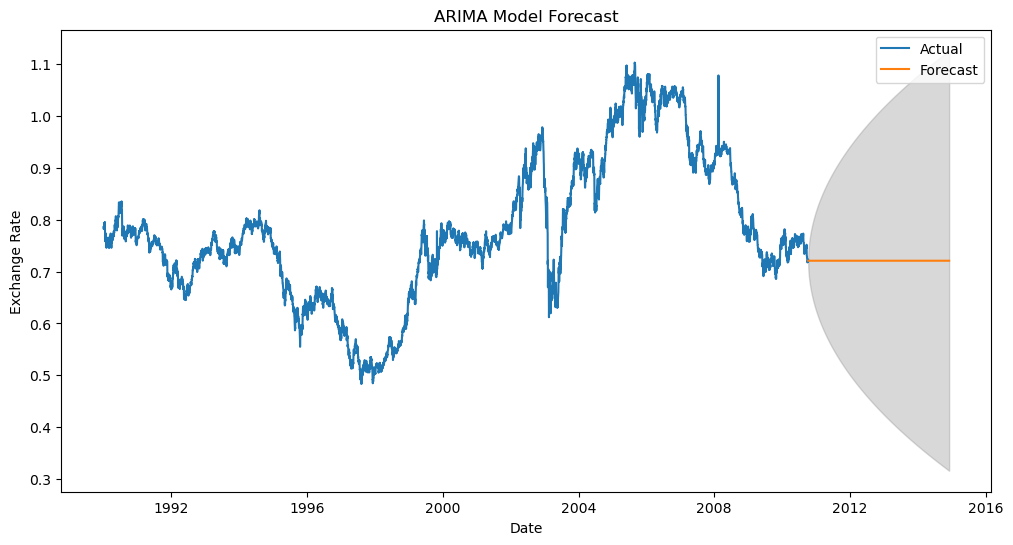

In [17]:
plt.figure(figsize=(12,6))
plt.plot(df['date'],df['Ex_rate'],label='Actual')
plt.plot(forecast_index,forecast_arima.predicted_mean,label='Forecast')
plt.fill_between(forecast_index,forecast_arima.conf_int().iloc[:,0],forecast_arima.conf_int().iloc[:,1],color='grey',alpha=0.3)
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Model Building - Exponential Smoothing

#### Model Selection

In [18]:
train,test=train_test_split(df['Ex_rate'],train_size=0.8,shuffle=False)

In [19]:
ses_model=ExponentialSmoothing(train,trend=None,seasonal=None)

In [20]:
ses_fit=ses_model.fit()

In [21]:
holt_model=ExponentialSmoothing(train,trend='add',seasonal=None)

In [22]:
holt_fit=holt_model.fit()

In [23]:
holt_winters_model=ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=12)

In [24]:
holt_winters_fit=holt_winters_model.fit()

#### Parameter Optimization

In [25]:
models={'SES': ses_fit, 'Holt': holt_fit, 'Holt-Winters': holt_winters_fit}
best_model_name=min(models,key=lambda k: models[k].aic)
best_model=models[best_model_name]

In [26]:
print(f"Best model based on AIC: {best_model_name}")

Best model based on AIC: SES


#### Model Fitting and Forecasting

In [27]:
forecast_es=best_model.forecast(len(test))

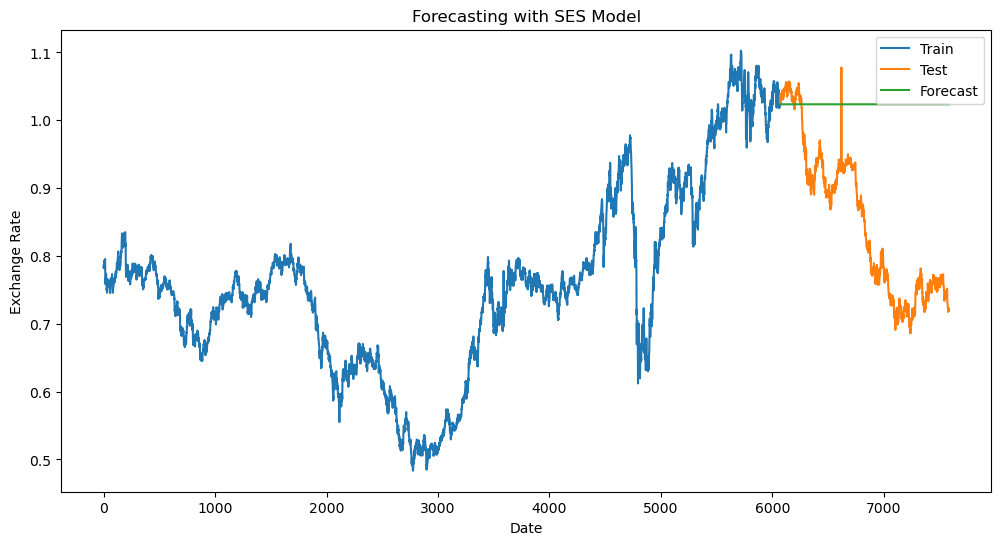

In [28]:
plt.figure(figsize=(12,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(test.index,forecast_es,label='Forecast')
plt.title(f'Forecasting with {best_model_name} Model')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### Evaluation and Comparison

#### Computing Error Metrics

In [29]:
forecast_arima_values=forecast_arima.predicted_mean

In [30]:
test_aligned=test[-len(forecast_arima_values):]

In [31]:
print(f"Length of test data: {len(test)}")
print(f"Length of ARIMA forecast: {len(forecast_arima_values)}")
print(f"Length of Exponential Smoothing forecast: {len(forecast_es)}")

Length of test data: 1518
Length of ARIMA forecast: 1518
Length of Exponential Smoothing forecast: 1518


In [32]:
def compute_metrics(actual,forecast):
    mae=mean_absolute_error(actual,forecast)
    rmse=np.sqrt(mean_squared_error(actual,forecast))
    mape=np.mean(np.abs((actual-forecast)/actual))*100
    return mae,rmse,mape

In [33]:
mae_arima,rmse_arima,mape_arima=compute_metrics(test,forecast_arima_values)

In [34]:
mae_es,rmse_es,mape_es=compute_metrics(test,forecast_es)

#### Model Comparison

In [35]:
print(f"ARIMA Model: MAE={mae_arima:.4f}, RMSE={rmse_arima:.4f}, MAPE={mape_arima:.2f}%")
print(f"Exponential Smoothing Model: MAE={mae_es:.4f}, RMSE={rmse_es:.4f}, MAPE={mape_es:.2f}%")

ARIMA Model: MAE=0.1314, RMSE=0.1695, MAPE=nan%
Exponential Smoothing Model: MAE=0.1776, RMSE=0.2054, MAPE=22.79%


#### Conclusion

In [36]:
if mae_arima<mae_es and rmse_arima<rmse_es:
    print("ARIMA model performs better based on MAE and RMSE.")
elif mae_es<mae_arima and rmse_es<rmse_arima:
    print("Exponential Smoothing model performs better based on MAE and RMSE.")
else:
    print("The models have comparable performance. Consider other factors like interpretability and computation time.")

ARIMA model performs better based on MAE and RMSE.


The model with the lowest MAE, RMSE, and MAPE generally provides the best fit for the data. Based on the error metrics, ARIMA model provided the best forecasts.